In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'zh'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'tuned-chinese-en'


In [4]:
# Parameters
model_size = "7b"
target_lang = "ru"
input_lang = "en"
type = "tuned-chinese"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [6]:

llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
    
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
if type == 'tuned-chinese-en':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese-en'
    latent = 'en'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [8]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    if latent == 'zh':
      df_en_target_input = df_en_target.copy()
      chinese = chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]
    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation': target_lang if target_lang != latent else f'{latent}_tgt'}, 
                                inplace=True)
    
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    if latent == 'zh':
      chinese = chinese.loc[chinese["word_original"].isin(df_en_target_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]

    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation_{target_lang}': target_lang if target_lang != latent else f'{latent}_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != latent else f'{latent}_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != latent:
    for i, row in df_en_target_input.iterrows():
        if row[latent].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_{latent}_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for ru 15 of 115 are single tokens
final length of df_zh_ru_en: 114


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != latent and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
df_en_target_input

,lang_ru,zh,ru,blank_prompt_original_ru,blank_prompt_translation_ru,blank_prompt_translation_masked_ru,error_ru,lang_en,en,blank_prompt_original_en,blank_prompt_translation_en,blank_prompt_translation_masked_en,error_en
0,ru,试,попытка,"An ""attempt"" is made when trying to achieve so...","Попытка"" предпринимается, когда пытаются чего-...","""___"" предпринимается, когда пытаются чего-то ...",no error,en,attempt,"An ""attempt"" is made when trying to achieve so...","An ""attempt"" is made when trying to achieve so...","An ""___"" is made when trying to achieve someth...",no error
1,ru,包,сумка,"A ""bag"" is used to carry items. Answer: ""bag"".",Сумка используется для переноски предметов. От...,"""___"" используется для переноски предметов. От...",no error,en,bag,"A ""bag"" is used to carry items. Answer: ""bag"".","A ""bag"" is used to carry items. Answer: ""bag"".","A ""___"" is used to carry items. Answer: ""bag"".",no error
2,ru,球,мяч,"A ""ball"" is used to play sports like soccer an...","Мяч используется для игры в такие виды спорта,...","""___"" используется для игры в такие виды спорт...",no error,en,ball,"A ""ball"" is used to play sports like soccer an...","A ""ball"" is used to play sports like soccer an...","A ""___"" is used to play sports like soccer and...",no error
3,ru,美,красота,"'""Beauty"" is a characteristic that provides a ...","''Красота - это характеристика, которая обеспе...","''""___"" - это характеристика, которая обеспечи...",no error,en,beauty,"'""Beauty"" is a characteristic that provides a ...","'""Beauty"" is a characteristic that provides a ...","'""___"" is a characteristic that provides a per...",no error
4,ru,书,книга,"A ""book"" is used to read stories. Answer: ""book"".","""Книга"" используется для чтения историй. Ответ...","""___"" используется для чтения историй. Ответ: ...",no error,en,book,"A ""book"" is used to read stories. Answer: ""book"".","A ""book"" is used to read stories. Answer: ""book"".","A ""___"" is used to read stories. Answer: ""book"".",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,ru,村,деревня,"A ""village"" is a small community or group of h...",Деревня - это небольшая община или группа домо...,"""___"" - это небольшая община или группа домов ...",no error,en,village,"A ""village"" is a small community or group of h...","A ""village"" is a small community or group of h...","A ""___"" is a small community or group of house...",no error
110,ru,德,добродетель,"A ""virtue"" is a quality considered morally goo...","Добродетель - это качество, которое считается ...","""___"" - это качество, которое считается мораль...",no error,en,virtue,"A ""virtue"" is a quality considered morally goo...","A ""virtue"" is a quality considered morally goo...","A ""___"" is a quality considered morally good o...",no error
111,ru,水,вода,"""A ""water"" is essential for life and is used f...","""Вода"" необходима для жизни и используется для...","""___"" необходима для жизни и используется для ...",no error,en,water,"""A ""water"" is essential for life and is used f...","""A ""water"" is essential for life and is used f...","""A ""___"" is essential for life and is used for...",no error
112,ru,波,волна,"A ""wave"" is a disturbance that transfers energ...","Волна - это возмущение, которое переносит энер...","""___"" - это возмущение, которое переносит энер...",no error,en,wave,"A ""wave"" is a disturbance that transfers energ...","A ""wave"" is a disturbance that transfers energ...","A ""___"" is a disturbance that transfers energy...",no error


In [12]:
chinese

,lang,word_original,word_translation,blank_prompt_original,blank_prompt_translation,blank_prompt_translation_masked
0,zh,attempt,试,"An ""attempt"" is made when trying to achieve so...","""试""是尝试达成某事的行为。答案：""试""。","""_""是尝试达成某事的行为。答案：""试""。"
1,zh,bag,包,"A ""bag"" is used to carry items. Answer: ""bag"".","""包""用来携带物品。答案：""包""。","""_""用来携带物品。答案：""包""。"
2,zh,ball,球,"A ""ball"" is used to play sports like soccer an...","""球""用来进行足球和篮球等运动。答案：""球""。","""_""用来进行足球和篮球等运动。答案：""球""。"
3,zh,beauty,美,"'""Beauty"" is a characteristic that provides a ...","""美""是提供愉悦或满足感知体验的特征。答案：""美""。","""_""是提供愉悦或满足感知体验的特征。答案：""美""。"
4,zh,book,书,"A ""book"" is used to read stories. Answer: ""book"".","""书""用来阅读故事。答案：""书""。","""_""用来阅读故事。答案：""书""。"
...,...,...,...,...,...,...
109,zh,village,村,"A ""village"" is a small community or group of h...","""村""是乡村地区一小群房屋的社区或群体。答案：""村""。","""_""是乡村地区一小群房屋的社区或群体。答案：""村""。"
110,zh,virtue,德,"A ""virtue"" is a quality considered morally goo...","""德""是人中被视为道德上好或可取的品质。答案：""德""。","""_""是人中被视为道德上好或可取的品质。答案：""德""。"
111,zh,water,水,"""A ""water"" is essential for life and is used f...","""水""对生命至关重要，用于饮用和清洁。答案：""水""。","""_""对生命至关重要，用于饮用和清洁。答案：""水""。"
112,zh,wave,波,"A ""wave"" is a disturbance that transfers energ...","""波""是一种通过物质或空间传递能量的扰动。答案：""波""。","""_""是一种通过物质或空间传递能量的扰动。答案：""波""。"


In [13]:
df_en_target_input

,lang_ru,zh,ru,blank_prompt_original_ru,blank_prompt_translation_ru,blank_prompt_translation_masked_ru,error_ru,lang_en,en,blank_prompt_original_en,blank_prompt_translation_en,blank_prompt_translation_masked_en,error_en
0,ru,试,попытка,"An ""attempt"" is made when trying to achieve so...","Попытка"" предпринимается, когда пытаются чего-...","""___"" предпринимается, когда пытаются чего-то ...",no error,en,attempt,"An ""attempt"" is made when trying to achieve so...","An ""attempt"" is made when trying to achieve so...","An ""___"" is made when trying to achieve someth...",no error
1,ru,包,сумка,"A ""bag"" is used to carry items. Answer: ""bag"".",Сумка используется для переноски предметов. От...,"""___"" используется для переноски предметов. От...",no error,en,bag,"A ""bag"" is used to carry items. Answer: ""bag"".","A ""bag"" is used to carry items. Answer: ""bag"".","A ""___"" is used to carry items. Answer: ""bag"".",no error
2,ru,球,мяч,"A ""ball"" is used to play sports like soccer an...","Мяч используется для игры в такие виды спорта,...","""___"" используется для игры в такие виды спорт...",no error,en,ball,"A ""ball"" is used to play sports like soccer an...","A ""ball"" is used to play sports like soccer an...","A ""___"" is used to play sports like soccer and...",no error
3,ru,美,красота,"'""Beauty"" is a characteristic that provides a ...","''Красота - это характеристика, которая обеспе...","''""___"" - это характеристика, которая обеспечи...",no error,en,beauty,"'""Beauty"" is a characteristic that provides a ...","'""Beauty"" is a characteristic that provides a ...","'""___"" is a characteristic that provides a per...",no error
4,ru,书,книга,"A ""book"" is used to read stories. Answer: ""book"".","""Книга"" используется для чтения историй. Ответ...","""___"" используется для чтения историй. Ответ: ...",no error,en,book,"A ""book"" is used to read stories. Answer: ""book"".","A ""book"" is used to read stories. Answer: ""book"".","A ""___"" is used to read stories. Answer: ""book"".",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,ru,村,деревня,"A ""village"" is a small community or group of h...",Деревня - это небольшая община или группа домо...,"""___"" - это небольшая община или группа домов ...",no error,en,village,"A ""village"" is a small community or group of h...","A ""village"" is a small community or group of h...","A ""___"" is a small community or group of house...",no error
110,ru,德,добродетель,"A ""virtue"" is a quality considered morally goo...","Добродетель - это качество, которое считается ...","""___"" - это качество, которое считается мораль...",no error,en,virtue,"A ""virtue"" is a quality considered morally goo...","A ""virtue"" is a quality considered morally goo...","A ""___"" is a quality considered morally good o...",no error
111,ru,水,вода,"""A ""water"" is essential for life and is used f...","""Вода"" необходима для жизни и используется для...","""___"" необходима для жизни и используется для ...",no error,en,water,"""A ""water"" is essential for life and is used f...","""A ""water"" is essential for life and is used f...","""A ""___"" is essential for life and is used for...",no error
112,ru,波,волна,"A ""wave"" is a disturbance that transfers energ...","Волна - это возмущение, которое переносит энер...","""___"" - это возмущение, которое переносит энер...",no error,en,wave,"A ""wave"" is a disturbance that transfers energ...","A ""wave"" is a disturbance that transfers energ...","A ""___"" is a disturbance that transfers energy...",no error


In [14]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                       | 0/114 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                                                                             | 1/114 [00:00<00:19,  5.75it/s]

  2%|███▋                                                                                                                                                                                                           | 2/114 [00:00<00:17,  6.36it/s]

  3%|█████▍                                                                                                                                                                                                         | 3/114 [00:00<00:15,  7.29it/s]

  4%|███████▎                                                                                                                                                                                                       | 4/114 [00:00<00:16,  6.76it/s]

  4%|█████████                                                                                                                                                                                                      | 5/114 [00:00<00:15,  7.03it/s]

  5%|██████████▉                                                                                                                                                                                                    | 6/114 [00:00<00:14,  7.27it/s]

  6%|████████████▋                                                                                                                                                                                                  | 7/114 [00:01<00:15,  7.04it/s]

  7%|██████████████▌                                                                                                                                                                                                | 8/114 [00:01<00:15,  6.71it/s]

  8%|████████████████▎                                                                                                                                                                                              | 9/114 [00:01<00:16,  6.43it/s]

  9%|██████████████████                                                                                                                                                                                            | 10/114 [00:01<00:16,  6.40it/s]

 10%|███████████████████▉                                                                                                                                                                                          | 11/114 [00:01<00:14,  7.01it/s]

 11%|█████████████████████▋                                                                                                                                                                                        | 12/114 [00:01<00:14,  6.89it/s]

 11%|███████████████████████▍                                                                                                                                                                                      | 13/114 [00:01<00:17,  5.91it/s]

 12%|█████████████████████████▎                                                                                                                                                                                    | 14/114 [00:02<00:16,  6.03it/s]

 13%|███████████████████████████                                                                                                                                                                                   | 15/114 [00:02<00:15,  6.42it/s]

 14%|████████████████████████████▉                                                                                                                                                                                 | 16/114 [00:02<00:15,  6.17it/s]

 15%|██████████████████████████████▋                                                                                                                                                                               | 17/114 [00:02<00:16,  6.06it/s]

 16%|████████████████████████████████▌                                                                                                                                                                             | 18/114 [00:02<00:16,  5.95it/s]

 17%|██████████████████████████████████▎                                                                                                                                                                           | 19/114 [00:02<00:15,  6.30it/s]

 18%|████████████████████████████████████▏                                                                                                                                                                         | 20/114 [00:03<00:13,  6.82it/s]

 18%|█████████████████████████████████████▉                                                                                                                                                                        | 21/114 [00:03<00:13,  6.79it/s]

 19%|███████████████████████████████████████▊                                                                                                                                                                      | 22/114 [00:03<00:13,  6.73it/s]

 20%|█████████████████████████████████████████▌                                                                                                                                                                    | 23/114 [00:03<00:12,  7.11it/s]

 21%|███████████████████████████████████████████▎                                                                                                                                                                  | 24/114 [00:03<00:12,  7.15it/s]

 22%|█████████████████████████████████████████████▏                                                                                                                                                                | 25/114 [00:03<00:12,  7.20it/s]

 23%|██████████████████████████████████████████████▉                                                                                                                                                               | 26/114 [00:03<00:11,  7.78it/s]

 24%|████████████████████████████████████████████████▊                                                                                                                                                             | 27/114 [00:04<00:11,  7.30it/s]

 25%|██████████████████████████████████████████████████▌                                                                                                                                                           | 28/114 [00:04<00:11,  7.41it/s]

 25%|████████████████████████████████████████████████████▍                                                                                                                                                         | 29/114 [00:04<00:11,  7.46it/s]

 26%|██████████████████████████████████████████████████████▏                                                                                                                                                       | 30/114 [00:04<00:12,  6.59it/s]

 27%|████████████████████████████████████████████████████████                                                                                                                                                      | 31/114 [00:04<00:12,  6.53it/s]

 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                    | 32/114 [00:04<00:12,  6.74it/s]

 29%|███████████████████████████████████████████████████████████▋                                                                                                                                                  | 33/114 [00:04<00:12,  6.68it/s]

 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                                | 34/114 [00:05<00:11,  6.67it/s]

 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                              | 35/114 [00:05<00:11,  6.93it/s]

 32%|█████████████████████████████████████████████████████████████████                                                                                                                                             | 36/114 [00:05<00:11,  6.64it/s]

 32%|██████████████████████████████████████████████████████████████████▊                                                                                                                                           | 37/114 [00:05<00:11,  6.44it/s]

 33%|████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 38/114 [00:05<00:12,  6.17it/s]

 34%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 39/114 [00:05<00:11,  6.36it/s]

 35%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 40/114 [00:05<00:10,  6.86it/s]

 36%|██████████████████████████████████████████████████████████████████████████                                                                                                                                    | 41/114 [00:06<00:10,  6.86it/s]

 37%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 42/114 [00:06<00:11,  6.38it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 43/114 [00:06<00:10,  6.62it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 44/114 [00:06<00:10,  6.99it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 45/114 [00:06<00:09,  7.16it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 46/114 [00:06<00:09,  7.36it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 47/114 [00:06<00:09,  7.32it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 48/114 [00:07<00:09,  7.29it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 49/114 [00:07<00:09,  7.07it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 50/114 [00:07<00:09,  6.42it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 51/114 [00:07<00:10,  5.94it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 52/114 [00:07<00:09,  6.52it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 53/114 [00:07<00:09,  6.72it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 54/114 [00:08<00:08,  6.87it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 55/114 [00:08<00:07,  7.38it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 56/114 [00:08<00:07,  7.35it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 57/114 [00:08<00:07,  7.13it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 58/114 [00:08<00:07,  7.09it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 59/114 [00:08<00:07,  7.15it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 60/114 [00:08<00:07,  7.60it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 61/114 [00:08<00:07,  6.91it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 62/114 [00:09<00:07,  6.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 63/114 [00:09<00:07,  6.60it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 64/114 [00:09<00:08,  6.21it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 65/114 [00:09<00:08,  5.90it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 66/114 [00:09<00:07,  6.25it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 67/114 [00:09<00:07,  6.70it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 68/114 [00:10<00:07,  6.33it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 69/114 [00:10<00:06,  6.51it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 70/114 [00:10<00:07,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 71/114 [00:10<00:07,  5.92it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 72/114 [00:10<00:07,  5.92it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 73/114 [00:10<00:06,  6.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 74/114 [00:11<00:05,  6.92it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 75/114 [00:11<00:05,  6.94it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 76/114 [00:11<00:05,  6.95it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 77/114 [00:11<00:05,  7.04it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 78/114 [00:11<00:05,  6.74it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 79/114 [00:11<00:05,  6.99it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 80/114 [00:11<00:05,  6.72it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 81/114 [00:12<00:04,  6.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 82/114 [00:12<00:04,  7.42it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 83/114 [00:12<00:04,  7.28it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 84/114 [00:12<00:04,  7.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 85/114 [00:12<00:03,  7.40it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 86/114 [00:12<00:04,  6.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 88/114 [00:13<00:03,  7.64it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 89/114 [00:13<00:03,  6.94it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 90/114 [00:13<00:03,  6.72it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 91/114 [00:13<00:03,  6.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 92/114 [00:13<00:03,  6.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 93/114 [00:13<00:03,  6.96it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 94/114 [00:13<00:03,  6.52it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 95/114 [00:14<00:03,  5.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 96/114 [00:14<00:02,  6.15it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 97/114 [00:14<00:02,  6.21it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 98/114 [00:14<00:02,  6.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 99/114 [00:14<00:02,  6.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 100/114 [00:14<00:01,  7.07it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 101/114 [00:15<00:01,  6.73it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 102/114 [00:15<00:01,  6.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 103/114 [00:15<00:01,  7.26it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 104/114 [00:15<00:01,  6.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 105/114 [00:15<00:01,  6.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 106/114 [00:15<00:01,  7.20it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 107/114 [00:15<00:00,  7.77it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 108/114 [00:16<00:00,  7.23it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 109/114 [00:16<00:00,  6.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 110/114 [00:16<00:00,  6.30it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 111/114 [00:16<00:00,  5.71it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 112/114 [00:16<00:00,  6.18it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 113/114 [00:16<00:00,  6.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:16<00:00,  6.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:16<00:00,  6.72it/s]

In [15]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [16]:
df["prompt"][0]

'English: "snow" - Русский: "снег"\nEnglish: "bridge" - Русский: "мост"\nEnglish: "item" - Русский: "предмет"\nEnglish: "red" - Русский: "красный"\nEnglish: "attempt" - Русский: "'

In [17]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(len(model.model.layers)):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [18]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.19it/s]

2it [00:01,  2.23it/s]

3it [00:01,  3.08it/s]

4it [00:01,  3.67it/s]

5it [00:01,  4.24it/s]

6it [00:01,  4.81it/s]

7it [00:01,  5.13it/s]

8it [00:02,  5.31it/s]

9it [00:02,  5.53it/s]

10it [00:02,  5.61it/s]

11it [00:02,  5.71it/s]

12it [00:02,  5.70it/s]

13it [00:02,  5.58it/s]

14it [00:03,  5.29it/s]

15it [00:03,  4.96it/s]

16it [00:03,  5.21it/s]

17it [00:03,  5.26it/s]

18it [00:03,  5.47it/s]

19it [00:04,  5.65it/s]

20it [00:04,  5.78it/s]

21it [00:04,  5.91it/s]

22it [00:04,  5.99it/s]

23it [00:04,  6.10it/s]

24it [00:04,  6.22it/s]

25it [00:05,  6.27it/s]

26it [00:05,  6.09it/s]

27it [00:05,  6.13it/s]

28it [00:05,  6.19it/s]

29it [00:05,  6.21it/s]

30it [00:05,  6.39it/s]

31it [00:05,  6.54it/s]

32it [00:06,  6.65it/s]

33it [00:06,  6.74it/s]

34it [00:06,  6.69it/s]

35it [00:06,  6.77it/s]

36it [00:06,  6.84it/s]

37it [00:06,  6.90it/s]

38it [00:06,  6.94it/s]

39it [00:07,  6.99it/s]

40it [00:07,  7.02it/s]

41it [00:07,  6.94it/s]

42it [00:07,  6.98it/s]

43it [00:07,  7.03it/s]

44it [00:07,  7.06it/s]

45it [00:07,  7.09it/s]

46it [00:08,  7.07it/s]

47it [00:08,  7.08it/s]

48it [00:08,  6.98it/s]

49it [00:08,  6.72it/s]

50it [00:08,  6.72it/s]

51it [00:08,  6.82it/s]

52it [00:08,  6.92it/s]

53it [00:09,  6.75it/s]

54it [00:09,  6.56it/s]

55it [00:09,  6.51it/s]

56it [00:09,  6.41it/s]

57it [00:09,  6.33it/s]

58it [00:09,  6.29it/s]

59it [00:10,  6.38it/s]

60it [00:10,  6.27it/s]

61it [00:10,  6.38it/s]

62it [00:10,  6.28it/s]

63it [00:10,  6.28it/s]

64it [00:10,  6.26it/s]

65it [00:11,  6.18it/s]

66it [00:11,  6.15it/s]

67it [00:11,  6.08it/s]

68it [00:11,  6.09it/s]

69it [00:11,  6.03it/s]

70it [00:11,  6.15it/s]

71it [00:12,  6.16it/s]

72it [00:12,  6.36it/s]

73it [00:12,  6.29it/s]

74it [00:12,  6.27it/s]

75it [00:12,  6.24it/s]

76it [00:12,  6.16it/s]

77it [00:12,  6.22it/s]

78it [00:13,  6.21it/s]

79it [00:13,  6.23it/s]

80it [00:13,  6.11it/s]

81it [00:13,  5.78it/s]

82it [00:13,  5.31it/s]

83it [00:14,  5.33it/s]

84it [00:14,  5.51it/s]

85it [00:14,  5.79it/s]

86it [00:14,  5.99it/s]

87it [00:14,  6.13it/s]

88it [00:14,  6.12it/s]

89it [00:15,  6.24it/s]

90it [00:15,  6.28it/s]

91it [00:15,  6.41it/s]

92it [00:15,  6.45it/s]

93it [00:15,  6.59it/s]

94it [00:15,  6.56it/s]

95it [00:15,  6.58it/s]

96it [00:16,  6.61it/s]

97it [00:16,  6.72it/s]

98it [00:16,  6.62it/s]

99it [00:16,  6.51it/s]

100it [00:16,  6.33it/s]

101it [00:16,  6.24it/s]

102it [00:17,  6.22it/s]

103it [00:17,  6.32it/s]

104it [00:17,  6.27it/s]

105it [00:17,  6.37it/s]

106it [00:17,  6.49it/s]

107it [00:17,  6.56it/s]

108it [00:17,  6.63it/s]

109it [00:18,  6.72it/s]

110it [00:18,  6.78it/s]

111it [00:18,  6.76it/s]

112it [00:18,  6.81it/s]

113it [00:18,  6.89it/s]

114it [00:18,  6.89it/s]

114it [00:18,  6.06it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


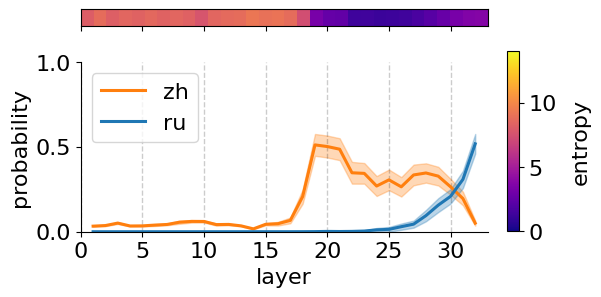

In [19]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

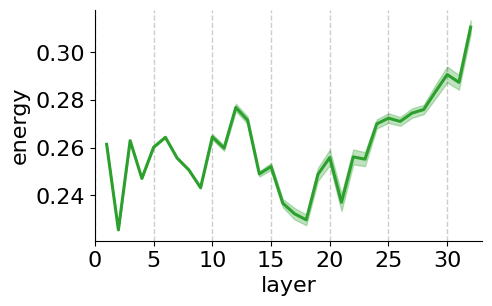

In [20]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')